# Errors on real Quantum Processing Units

In [1]:
# Qiskit setup
from qiskit_ibm_runtime import QiskitRuntimeService



In [2]:
# This uses a local simulator
from qiskit_aer import AerSimulator

#Load the Runtime primitive and session
from qiskit_ibm_runtime import Options, Session, SamplerV2 as Sampler

# #Use the least busy backend
# service = QiskitRuntimeService(channel='ibm_quantum')
# backend = service.least_busy()
# print(backend.name)
# This generates a simulator that mimics the real quantum system
backend_sim = AerSimulator()

#Import an estimator, this time from qiskit (we import from Runtime for real hardware)
from qiskit.primitives import BackendSampler
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy()
print(backend.name)
sampler = Sampler(mode=backend)
sampler.options.default_shots = 100


ibm_sherbrooke


In [3]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Options, Session, SamplerV2 as Sampler
backend_sim = AerSimulator()
simulator = AerSimulator()

#Import an estimator, this time from qiskit (we import from Runtime for real hardware)
from qiskit.primitives import BackendSampler
sampler = BackendSampler(backend = backend_sim)
import numpy as np
from qiskit.visualization import plot_bloch_vector, plot_histogram
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit, Parameter
from qiskit import QuantumCircuit, transpile
from qiskit.result import marginal_counts
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator


import matplotlib.ticker as tck



/var/folders/wf/3snlfs053z5cdskpx0b4lfpm0000gn/T/ipykernel_26122/3344170123.py:8: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler = BackendSampler(backend = backend_sim)


# **Estimate $ T_1 $ Decay Time**  

As you have seen during the lectures, when a qubit is initialized in the excited state $ |1\rangle $, it tends to decay to the ground state $ |0\rangle $ over time due to **energy relaxation**. This process is characterized by the **longitudinal relaxation time** $ T_1 $, which measures how long a qubit retains its excited state before spontaneously decaying.  

## **Physical Origin of $ T_1 $ Relaxation**  
The $ T_1 $ relaxation process occurs due to interactions between the qubit and its environment, such as:  
- **Spontaneous emission**: The qubit emits a photon and relaxes to the ground state.  
- **Dielectric losses**: Energy dissipates into surrounding materials in superconducting qubits.  
- **Purcell effect**: Coupling to a resonator can accelerate the decay rate.  

## **Experimental Measurement of $ T_1 $**
To experimentally determine $ T_1 $, we perform the following steps:  

1. **Prepare the qubit in the excited state $ |1\rangle $**  
   - Apply a $ \pi $-pulse (a 180° rotation) to an initially $ |0\rangle $ state.  
2. **Wait for a variable delay time $ t $**  
   - Allow the system to evolve freely, during which the qubit decays to $ |0\rangle $.  
3. **Measure the probability of finding the qubit in $ |1\rangle $**  
   - Perform a projective measurement in the computational basis.  
4. **Fit the data to an exponential decay model**  
   - The probability of remaining in $ |1\rangle $ follows:  

$$
P_1 (t) = P_1(0) e^{-t/T_1}
$$

where $ P_1(0) $ is the initial population in $ |1\rangle $, and $ P_1(t) $ is the probability of remaining in $ |1\rangle $ after time $ t $.  

## **Visualization of the Decay Process**
Plotting $ P_1(t) $ as a function of $ t $ on a semi-log scale should yield a straight line with a slope of $ -1/T_1 $. The characteristic decay time $ T_1 $ can be extracted by fitting the experimental data to the exponential model.  

## **Impact of $ T_1 $ on Quantum Computation**
- **Gate fidelity**: A long $ T_1 $ is crucial for high-fidelity quantum gates, as energy relaxation can lead to errors.  
- **Qubit initialization**: Short $ T_1 $ can enable faster qubit reset, improving circuit execution speed.  
- **Quantum error correction**: If $ T_1 $ is too short, it limits the time available for error correction before information is lost.  

By measuring and optimizing $ T_1 $, we can better understand and mitigate decoherence, improving the performance of quantum devices. Now, let's proceed with the experiment to determine the $ T_1 $ of our qubit. 


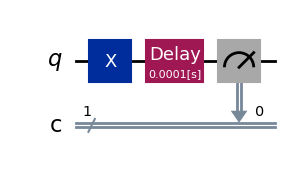

In [4]:
qc = QuantumCircuit(1,1)
qc.x(0)
# we add a delay to the circuit
T = 100e-6 # 100 microseconds
qc.delay(T,unit="s") # This is a delay of 100 microseconds 

qc.measure(0,0)
qc.draw('mpl')

# We can now simulate the circuit on a QPU

In [5]:

#Import an estimator, this time from qiskit (we import from Runtime for real hardware)
from qiskit.primitives import BackendSampler
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy()
print(backend.name)
sampler = Sampler(mode=backend)
sampler.options.default_shots = 100



ibm_sherbrooke


## We run the circuit on a specific qubit (# 80)

In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


physical_qubit = 80

pm = generate_preset_pass_manager(optimization_level=3, backend=backend, scheduling_method='asap', initial_layout=[physical_qubit]) 

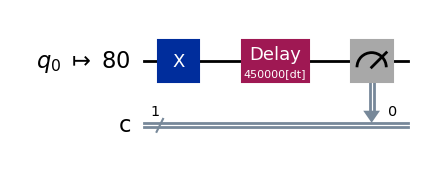

In [7]:
qc_ibm = pm.run(qc)
qc_ibm.draw('mpl', idle_wires=False)


In [8]:
sampler = Sampler(mode=backend)
job = sampler.run([(qc_ibm)], shots = 100)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cz5c6b1h0kc000891qyg
>>> Job Status: QUEUED


In [9]:
print(f">>> Job Status: {job.status()}")

>>> Job Status: QUEUED


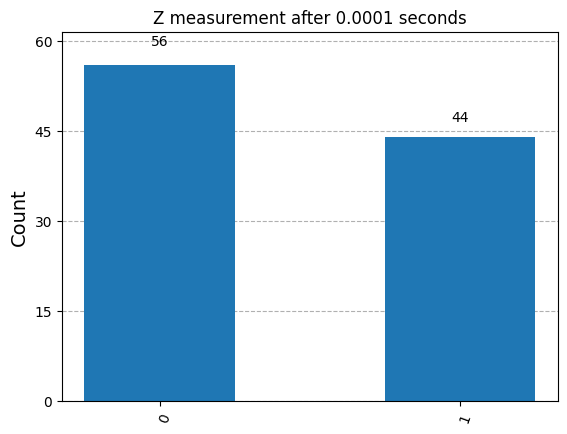

In [10]:
res = job.result()
res[0].data.c.get_counts()
plot_histogram(res[0].data.c.get_counts(),title= f"Z measurement after {T} seconds")

### We can now run this circuit for different delay times

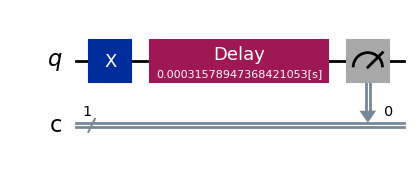

In [14]:
# Initialize the quantum circuit for different delays
# In this case you cannot create a parametric circuit, so you need to create a new circuit for each delay

delays = np.linspace(0,2e-3, 20) 
qcs = []
for delay in delays:
    qc = QuantumCircuit(1,1)
    qc.x(0)
    qc.delay(delay,unit="s") # This is a delay of 100 microseconds
    qc.measure(0,0)
    qcs.append(qc)

qcs[3].draw('mpl')

In [12]:
physical_qubit = 46
pm = generate_preset_pass_manager(optimization_level=3, backend=backend, scheduling_method='asap', timing_constraints="1" , initial_layout=[physical_qubit]) 
qcs_ibm = [pm.run(qc) for qc in qcs]

/Users/gregoireleboucher/anaconda3/envs/QC/lib/python3.12/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 473684 [dt] = 1.052631e-04 [s] from 1.052632e-04 [s]
  warnings.warn(
/Users/gregoireleboucher/anaconda3/envs/QC/lib/python3.12/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 947368 [dt] = 2.105262e-04 [s] from 2.105263e-04 [s]
  warnings.warn(
/Users/gregoireleboucher/anaconda3/envs/QC/lib/python3.12/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 1421053 [dt] = 3.157896e-04 [s] from 3.157895e-04 [s]
  warnings.warn(
/Users/gregoireleboucher/anaconda3/envs/QC/lib/python3.12/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 1894737 [dt] = 4.210527e-04 [s] from 4.210526e-04 [s]
  warnings.warn(
/Users/gregoireleboucher/anaconda3/envs/QC/lib/python3.12/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 2368421 [dt] = 5.263158

In [15]:
# sampler = Sampler(mode=sim)

#sampler = Sampler(mode=backend)
num_shots = 100
job = sampler.run(qcs_ibm, shots = num_shots)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cz5c9a510wx0008bmkfg
>>> Job Status: QUEUED


In [16]:
print(f">>> Job Status: {job.status()}")

>>> Job Status: QUEUED


In [17]:
res = job.result()

In [18]:
# Extract the probabilities of measuring 1 for each delay
probs = []
sigmas = []
res = job.result()
for i in range(len(delays)):
    counts = res[i].data.c.get_counts()
    probs.append(counts.get("1",0)/num_shots) 
    sigmas.append(np.sqrt((probs[i]*(1-probs[i]))/num_shots))


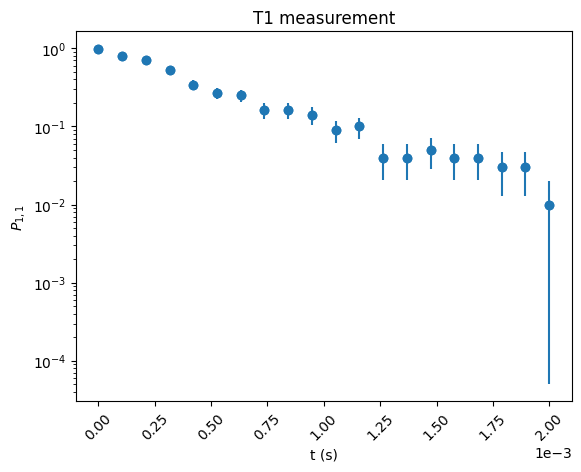

In [22]:
import matplotlib.pyplot as plt

plt.scatter(delays, probs)
plt.xlabel(r"t (s)")
plt.ylabel(r"$P_{1,1}$")
plt.errorbar(delays, probs, yerr=sigmas, fmt='o')
plt.yscale("log")
plt.title("T1 measurement")

plt.xticks(rotation=45)  # Rotate labels by 45 degrees to prevent overlap
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))  # Use scientific notation for x-axis
plt.show()

# As expected the result resembles an exponential. 
### We can fit the decay constant ($T_1$) by fitting with an exponential
$$
P_{11}(t) = e^{-\frac{t}{T_1}}
$$
using scipy.optimize package

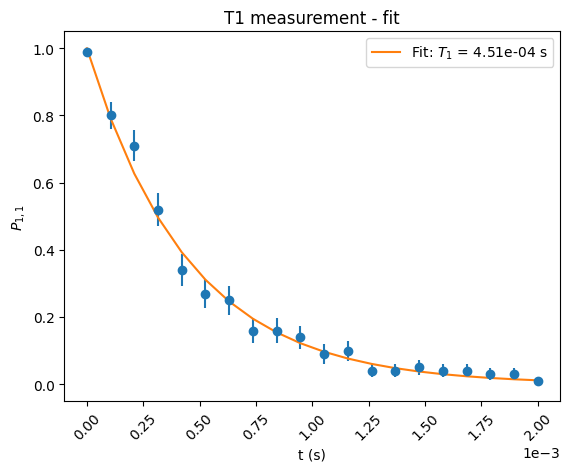

In [28]:
from scipy.optimize import curve_fit

# Define the exponential function
def exp_decay(t, T1):
    return np.exp(-t / T1)

# Fit the data
popt, pcov = curve_fit(exp_decay, delays, probs)
T1 = popt[0]

# Plot the results
plt.errorbar(delays, probs, yerr=sigmas, fmt='o')
plt.xlabel("t (s)")
plt.ylabel(r"$P_{1,1}$")
plt.title("T1 measurement - fit")


plt.xticks(rotation=45)  # Rotate labels by 45 degrees to prevent overlap
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))  # Use scientific notation for x-axis
plt.plot(delays, exp_decay(delays, T1), '-', label=f'Fit: $T_1$ = {T1:.2e} s')

plt.legend()
plt.show()

# **$T_2$ Measurement**  

## **$T_2$ Rate and Environmental Decoherence**  
The $T_2$ rate describes the rate at which the environment **measures** the system, or in another phrasing, the rate at which the state:

$$ 
|+\rangle\langle + | = \frac{1}{\sqrt{2}} (|0\rangle + |1\rangle) \quad \rightarrow \quad \frac{1}{2} (|0\rangle\langle0| + |1\rangle\langle1|) 
$$

loses coherence and evolves into a classical probabilistic mixture of $|0\rangle$ and $|1\rangle$.  

To measure $T_2$, we initialize the system on the **equator** of the Bloch sphere, where the quantum state is in a **superposition**. We then let it **idle for a time $T$**, allowing the environment to interact with it. Finally, we **project the state back to the computational basis** and measure. The coherence decay follows an exponential function:

$$
P_+ (t) = P_+(0) e^{-t/T_2}
$$

where $P_+(t)$ is the probability of finding the system in the original superposition state at time $t$.  

---  

# **$T_2$ Ramsey Experiment**  

A **Ramsey experiment** is a standard method to measure $T_2^*$, the **dephasing time** that includes inhomogeneous broadening effects. The steps for the Ramsey sequence are:  

1. **Prepare the qubit in $ |+\rangle $**  
   - Apply a **Hadamard gate** (or a $ \frac{\pi}{2} $ pulse) to transform $ |0\rangle $ into $ |+\rangle $.  
2. **Let the qubit evolve freely for a time $ T $**  
   - During this time, environmental noise and frequency detuning lead to phase accumulation.  
3. **Apply a second Hadamard gate**  
   - This projects the qubit state back onto the computational basis.  
4. **Measure in the computational basis**  
   - The probability oscillates as a function of $ T $, forming **Ramsey fringes**.  

The observed probability oscillates as:

$$
P_0 (t) = \frac{1}{2} \left( 1 + e^{-t/T_2^*} \cos(\Delta \omega t) \right)
$$

where:  
- $ T_2^* $ is the **inhomogeneous dephasing time**, limited by frequency fluctuations and noise.  
- $ \Delta \omega $ is the detuning between the qubit frequency and the applied control field.  

By fitting the **envelope** of the Ramsey fringes to an exponential decay, we extract $ T_2^* $. The true **$T_2$ (spin echo dephasing time)** can be extracted using a **Hahn echo** experiment, which removes inhomogeneous broadening effects.  

---  

These experiments are essential for understanding **quantum coherence** and improving the performance of qubits in quantum processors. A long $T_2$ allows for better **gate operations**, **error correction**, and **long-lived quantum memory**.

<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
/var/folders/wf/3snlfs053z5cdskpx0b4lfpm0000gn/T/ipykernel_26122/3420884329.py:4: SyntaxWarning: invalid escape sequence '\o'
  omega = Parameter("$\omega$")


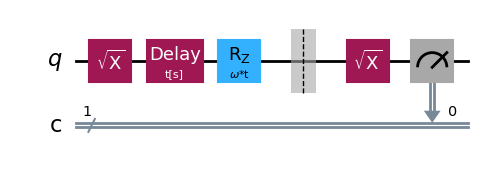

In [23]:
# Generic circuit
T_omega = 100e-6 # 100 microseconds
f = 1/T_omega
omega = Parameter("$\omega$")
t = Parameter('t')

qc_ramsey = QuantumCircuit(1,1)
qc_ramsey.sx(0)
qc_ramsey.delay(t, unit='s')
qc_ramsey.rz(omega *t,0)
qc_ramsey.barrier()
qc_ramsey.sx(0)
qc_ramsey.measure(0,0)
qc_ramsey.draw('mpl')

Due to current compilation constraints, we are unable to compile circuits that include **delays** or **parametric circuits** directly. As a result, we must construct and execute each circuit **individually**, specifying the required parameters explicitly for every experiment. 

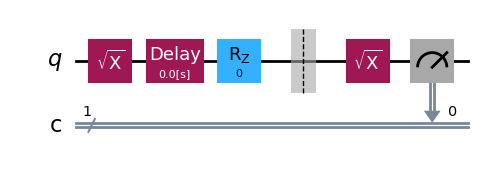

In [24]:
delays_T2 = list(np.arange(0, 250e-6, 20e-6))
T_omega = 50e-6 # 100 microseconds
f = 1/T_omega
omega = 2*np.pi*f
qc_ramsey_circuits = []

for delay in delays_T2:
    qc_ramsey = QuantumCircuit(1,1)
    qc_ramsey.sx(0)
    qc_ramsey.delay(delay, unit='s')
    qc_ramsey.rz(omega * delay,0)
    qc_ramsey.barrier()
    qc_ramsey.sx(0)
    qc_ramsey.measure(0,0)
    qc_ramsey_circuits.append(qc_ramsey)
qc_ramsey_circuits[0].draw('mpl')

In [25]:

#Import an estimator, this time from qiskit (we import from Runtime for real hardware)
from qiskit.primitives import BackendSampler
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.backend("ibm_kyiv")
print(backend.name)
sampler = Sampler(mode=backend)
sampler.options.default_shots = 100


ibm_kyiv


In [26]:
# physical_qubit = 46

pm = generate_preset_pass_manager(optimization_level=3, backend=backend, scheduling_method='asap')#, initial_layout=[physical_qubit]) 
qcs_ibm = [pm.run(qc) for qc in qc_ramsey_circuits]


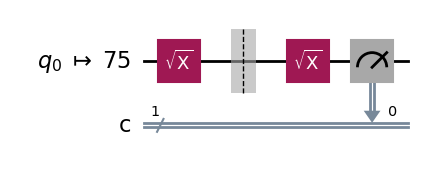

In [29]:

qcs_ibm[0].draw('mpl', idle_wires=False)

In [30]:
# sampler = Sampler(mode=sim)

#sampler = Sampler(mode=backend)
num_shots = 100
job = sampler.run(qcs_ibm, shots = num_shots)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cz5f8pa10wx0008bn5m0
>>> Job Status: QUEUED


In [31]:
print(f">>> Job Status: {job.status()}")

>>> Job Status: QUEUED


In [32]:
res = job.result()
res[2].data.c.get_counts()

{'0': 57, '1': 43}

In [33]:
# Extract the probabilities of measuring 1 for each delay
probs = []
sigmas = []
for i in range(len(delays_T2)):
    counts = res[i].data.c.get_counts()
    probs.append(counts.get("1",0)/num_shots) 
    sigmas.append(np.sqrt((probs[i]*(1-probs[i]))/num_shots))

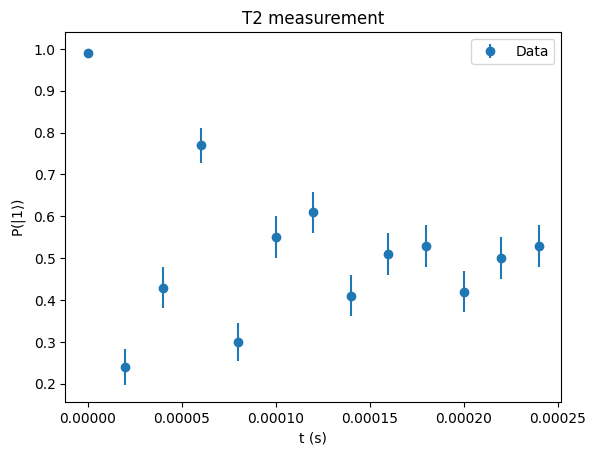

In [34]:

# Plot the results
plt.errorbar(delays_T2, probs,yerr=sigmas, fmt='o', label='Data')
plt.xlabel("t (s)")
plt.ylabel(r"P($|1\rangle$)")
plt.title("T2 measurement")
plt.legend()
plt.show()

## Fit with:
$$
f(t)=a e^{-t / T_{2^*}} \cdot \cos (2 \pi f t+\phi)+b
$$

In [36]:

from scipy.optimize import curve_fit


# Define the fitting function
def fit_func(x,a, tau, freq,phi1 ,base):
    """Function to fit: amp * exp(-x / tau) * cos(2 * pi * freq * x + phi) + base"""
    return a*np.exp(-x / tau) * (np.cos(2 * np.pi * freq * x  + phi1)) + base
                                  
# Initial guess for the parameters
initial_guess = [0.5, delays_T2[-1], omega/(2*np.pi),0.0,0.5]  # Initial guesses for [a, T2_star, f, phi, b]
bounds = ([0, 0, 0, -np.pi, 0], [1, 1e-2, 2*omega/(2*np.pi), np.pi, 1])  # Adjust bounds

for i in range(len(initial_guess)):
    if initial_guess[i] < bounds[0][i] or initial_guess[i] > bounds[1][i]:
        print (f"Initial guess {initial_guess[i]} is out of bounds {bounds[0][i]} - {bounds[1][i]}")
        
    

popt, pcov = curve_fit(fit_func, delays_T2, probs, p0=initial_guess, bounds=bounds)
popt

array([4.97094702e-01, 9.68816908e-05, 1.73998348e+04, 1.22085203e-01,
       5.00810408e-01])

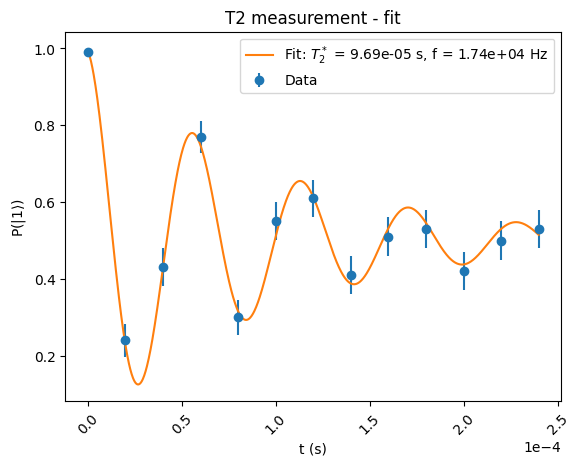

Fitted parameters:
a = 0.50
T2* = 9.69e-05 s
f = 1.74e+04 Hz
phi = 0.12
b = 0.50


In [37]:

# Extract the fitted parameters
a,T2_star, f, phi1, b = popt
# Create a smooth delay range for plotting, ensuring it spans the original delays
delay_range = np.linspace(min(delays_T2), max(delays_T2), 1_000)  # Use a fine grid for a smooth curve plot

# Plotting the original data and the fitted curve
plt.errorbar(delays_T2, probs,yerr=sigmas, fmt='o', label='Data')
plt.plot(delay_range, fit_func(delay_range, *popt), label=f'Fit: $T_2^*$ = {T2_star:.2e} s, f = {f:.2e} Hz')  # Plot the fitted curve

plt.xticks(rotation=45)  # Rotate labels by 45 degrees to prevent overlap
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))  # Use scientific notation for x-axis
plt.xlabel("t (s)")
plt.ylabel(r"P($|1\rangle$)")
plt.title("T2 measurement - fit")
plt.legend()
plt.show()

# Print the fitted parameters
print(f"Fitted parameters:")
print(f"a = {a:.2f}")
print(f"T2* = {T2_star:.2e} s")
print(f"f = {f:.2e} Hz")
print(f"phi = {phi1:.2f}")
print(f"b = {b:.2f}")


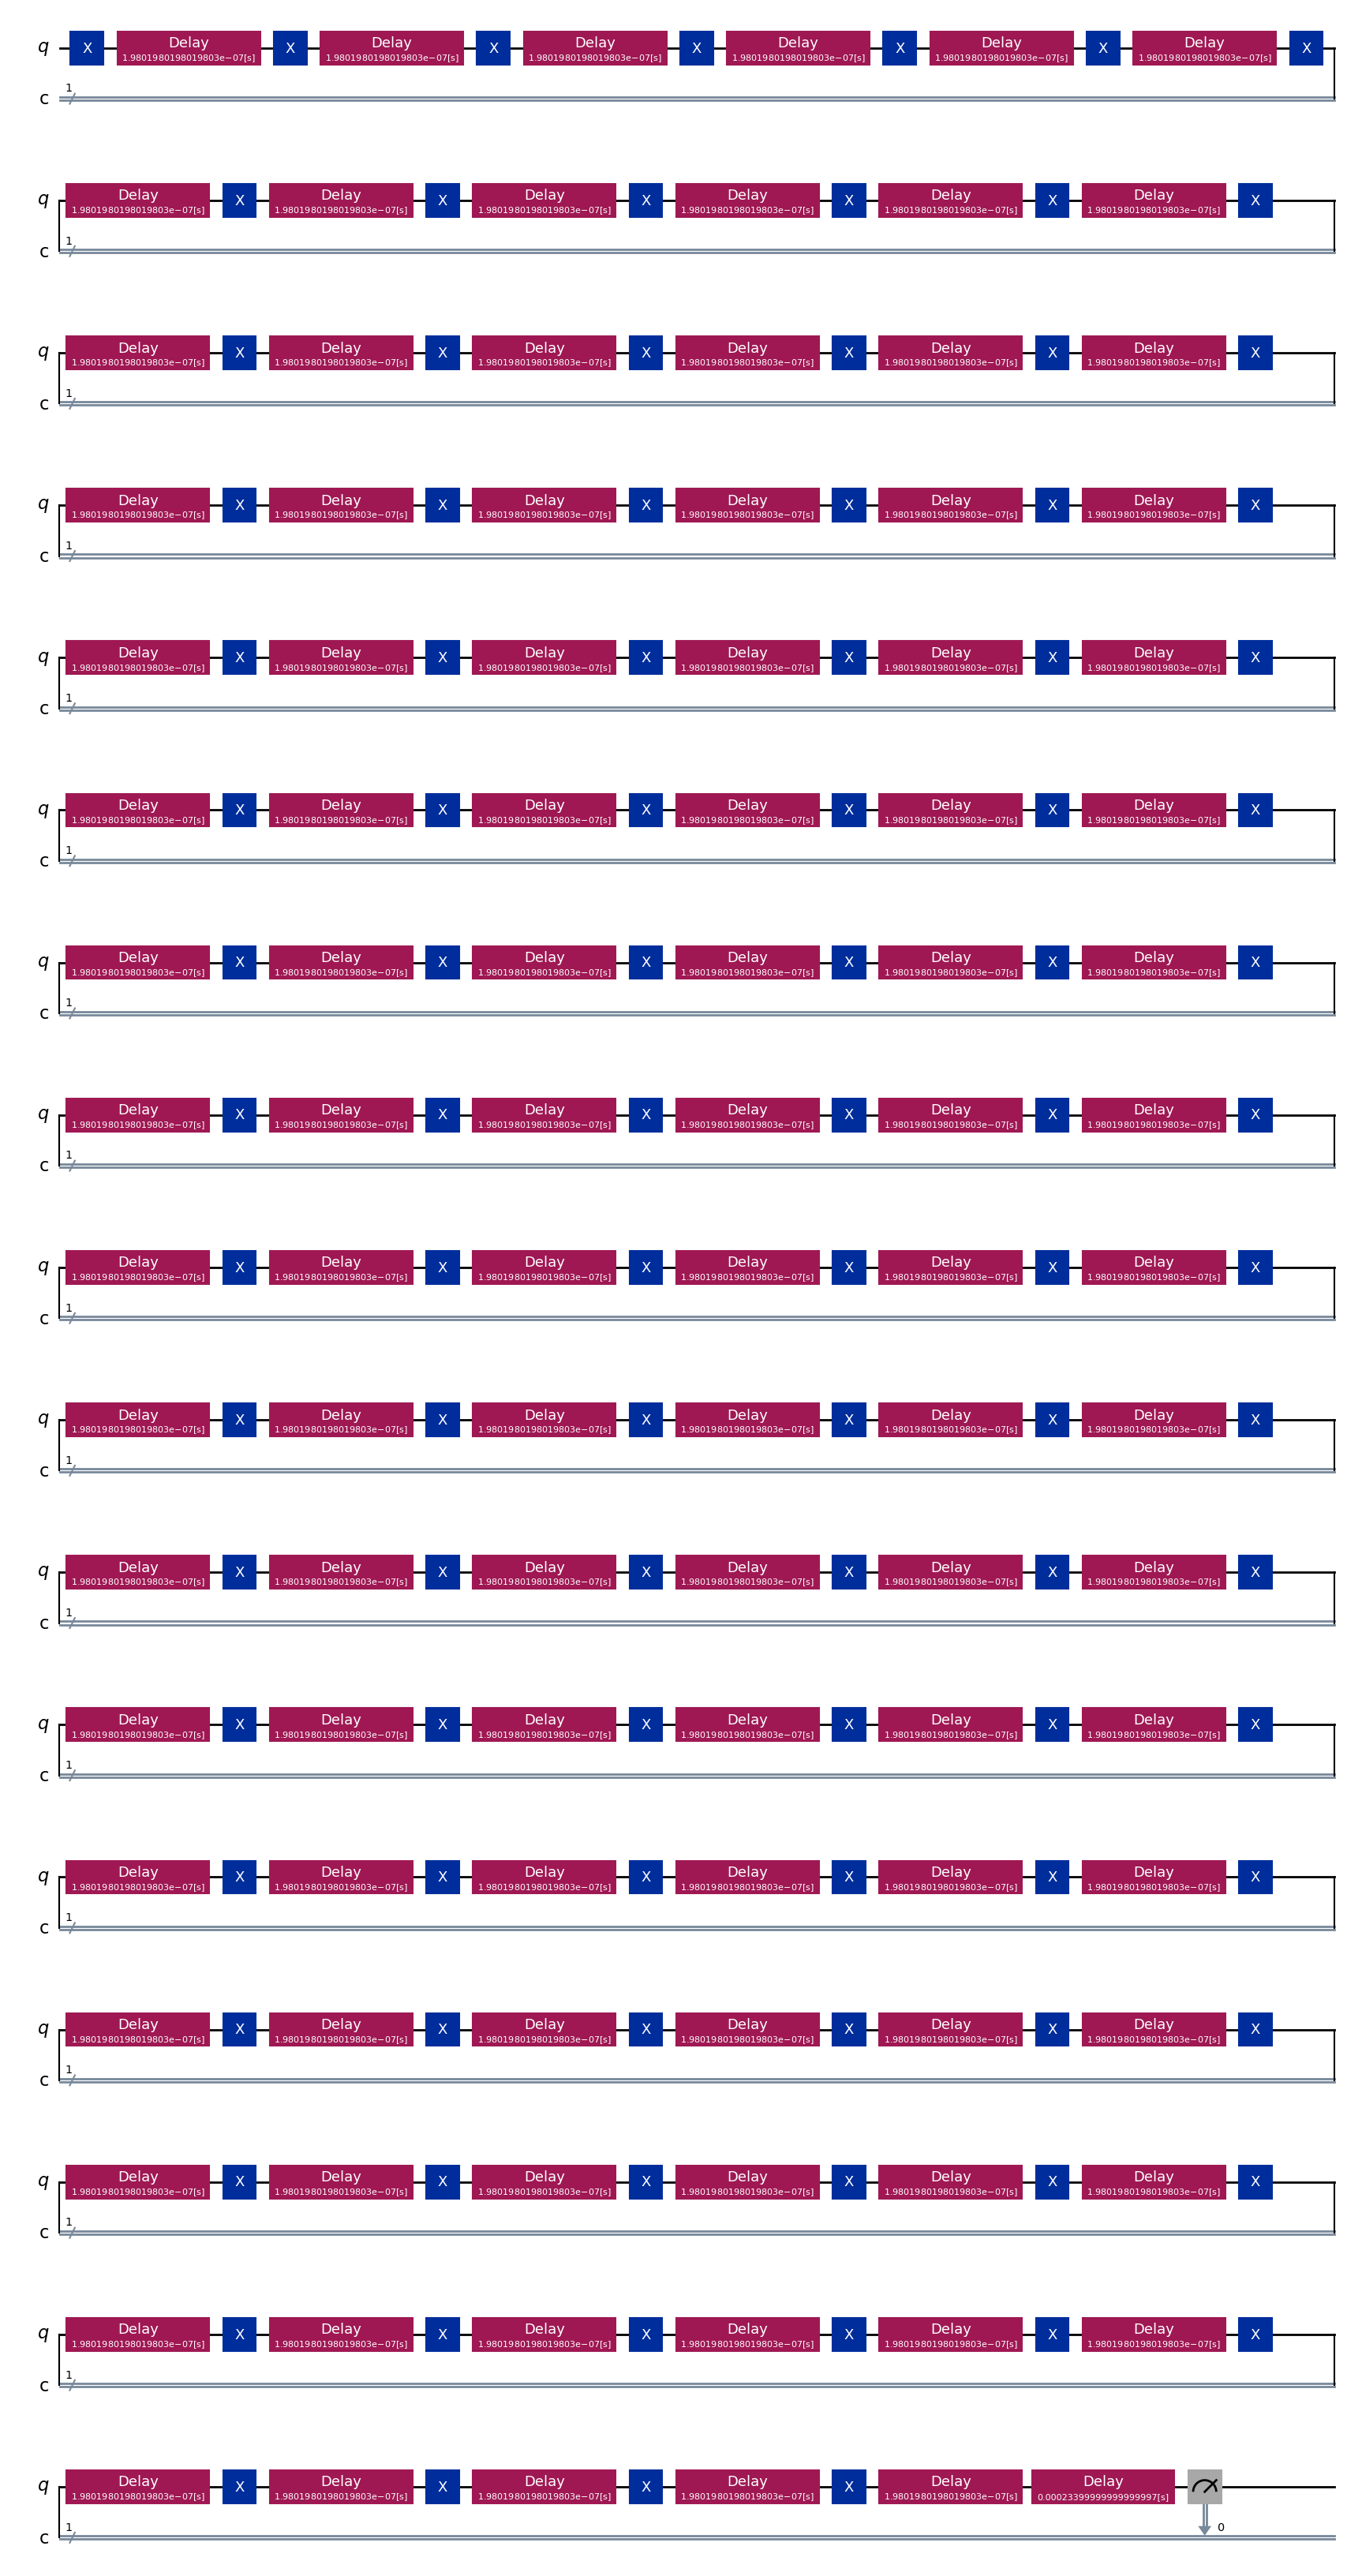

In [129]:
delay = 2e-5
qcs = []
n_identities = 2000
x_time = 6e-8
step = 50
for k in range(0, n_identities, step):
    qc = QuantumCircuit(1,1)
    qc.x(0)
    d = delay / (2*k + 1)
    qc.delay(d,unit="s")
    for _ in range (2*k): 
        qc.x(0)
        qc.delay(d,unit='s')
    add_delay = 2 * (n_identities - k) * x_time
    qc.delay(add_delay, unit="s")
    qc.measure(0,0)
    qcs.append(qc)

qcs[1].draw('mpl')

In [130]:
physical_qubit = 46
pm = generate_preset_pass_manager(optimization_level=3, backend=backend, scheduling_method='asap', timing_constraints="1" , initial_layout=[physical_qubit]) 
qcs_ibm = [pm.run(qc) for qc in qcs]

/Users/gregoireleboucher/anaconda3/envs/QC/lib/python3.12/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 891 [dt] = 1.980000e-07 [s] from 1.980198e-07 [s]
  warnings.warn(
/Users/gregoireleboucher/anaconda3/envs/QC/lib/python3.12/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 448 [dt] = 9.955556e-08 [s] from 9.950249e-08 [s]
  warnings.warn(
/Users/gregoireleboucher/anaconda3/envs/QC/lib/python3.12/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 299 [dt] = 6.644444e-08 [s] from 6.644518e-08 [s]
  warnings.warn(
/Users/gregoireleboucher/anaconda3/envs/QC/lib/python3.12/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 224 [dt] = 4.977778e-08 [s] from 4.987531e-08 [s]
  warnings.warn(
/Users/gregoireleboucher/anaconda3/envs/QC/lib/python3.12/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 180 [dt] = 4.000000e-08 [s] from 3.99

In [131]:
num_shots = 100
job = sampler.run(qcs_ibm, shots = num_shots)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cz5gzfn10wx0008bnhx0
>>> Job Status: QUEUED


In [132]:
probs = []
sigmas = []
res = job.result()
for i in range(n_identities//step):
    counts = res[i].data.c.get_counts()
    probs.append(counts.get("1",0)/num_shots) 
    sigmas.append(np.sqrt((probs[i]*(1-probs[i]))/num_shots))

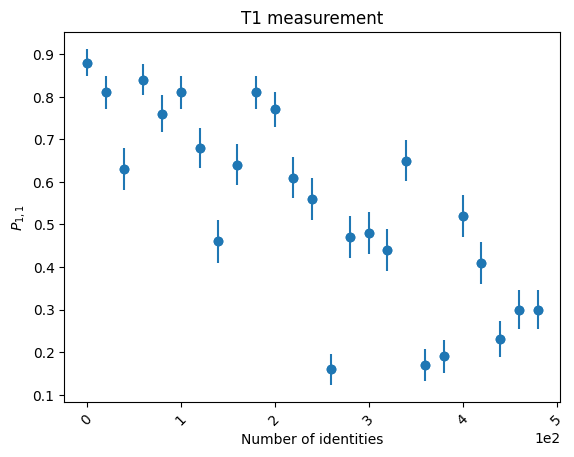

In [90]:
plt.scatter(range(0, n_identities, step), probs)
plt.xlabel("Number of identities")
plt.ylabel(r"$P_{1,1}$")
plt.errorbar(range(0, n_identities, step), probs, yerr=sigmas, fmt='o')
plt.title("T1 measurement")

plt.xticks(rotation=45)  # Rotate labels by 45 degrees to prevent overlap
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))  # Use scientific notation for x-axis
plt.show()

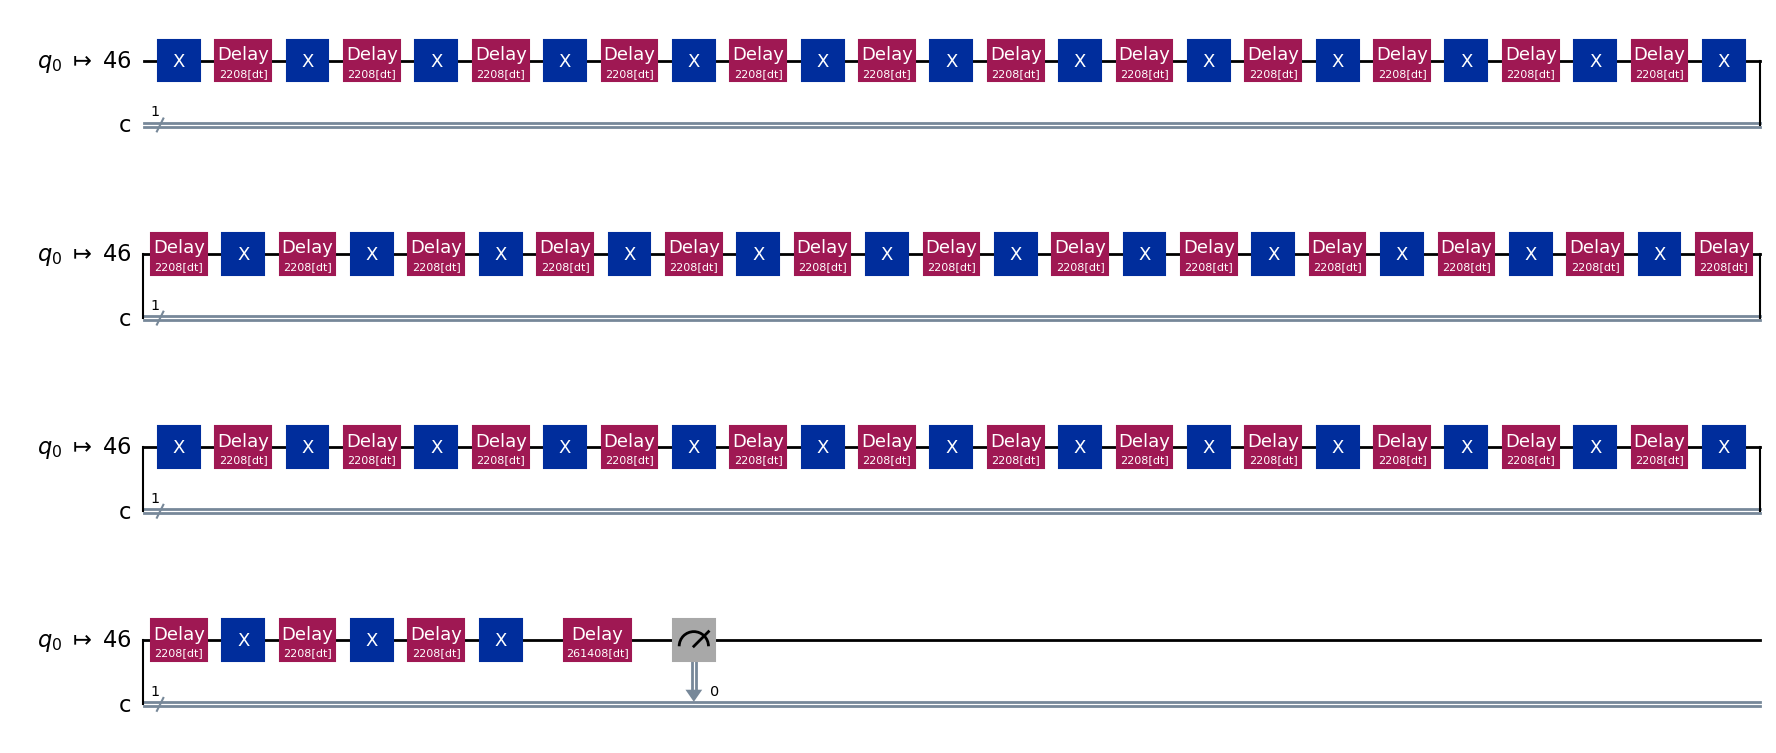

In [95]:
qcs_ibm[1].draw('mpl', idle_wires=False)

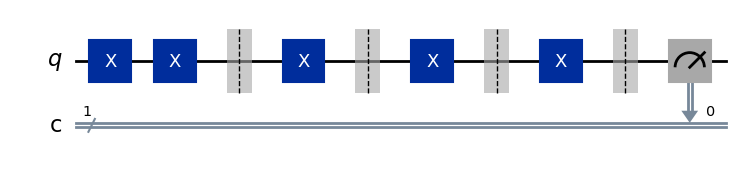

In [133]:
delay = 2e-5
qcs = []
n_identities = 200
x_time = 6e-8
step = 2
for k in range(0, n_identities, step):
    qc = QuantumCircuit(1,1)
    qc.x(0)
    for _ in range (2*k): 
        qc.x(0)
        qc.barrier()
    qc.measure(0,0)
    qcs.append(qc)

qcs[1].draw('mpl')

In [134]:
physical_qubit = 46
pm = generate_preset_pass_manager(optimization_level=3, backend=backend, scheduling_method='asap', timing_constraints="1" , initial_layout=[physical_qubit]) 
qcs_ibm = [pm.run(qc) for qc in qcs]

In [135]:
num_shots = 100
job = sampler.run(qcs_ibm, shots = num_shots)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cz5h1f5kvm9g008gcxv0
>>> Job Status: QUEUED


In [ ]:
probs = []
sigmas = []
res = job.result()
for i in range(n_identities//step):
    counts = res[i].data.c.get_counts()
    probs.append(counts.get("1",0)/num_shots) 
    sigmas.append(np.sqrt((probs[i]*(1-probs[i]))/num_shots))

In [ ]:
plt.scatter(range(0, n_identities, step), probs)
plt.xlabel("Number of identities")
plt.ylabel(r"$P_{1,1}$")
plt.errorbar(range(0, n_identities, step), probs, yerr=sigmas, fmt='o')
plt.title("T1 measurement")

plt.xticks(rotation=45)  # Rotate labels by 45 degrees to prevent overlap
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))  # Use scientific notation for x-axis
plt.show()

In [117]:
qc = QuantumCircuit(2, 2)